In [55]:
import os

import matplotlib.pyplot as plt
import tensorflow as tf
from keras import backend as K
from skimage import io

from data_generator import *
from dice_loss import *
from unet import *

from tensorflow.keras.preprocessing.image import (
    ImageDataGenerator,
    img_to_array,
    load_img
)

In [18]:
TRAIN_PATH = 'data/train/'
XTRAIN_PATH = f'{TRAIN_PATH}/image'
YTRAIN_PATH = f'{TRAIN_PATH}/label'

TEST_PATH = 'data/test/'
XTEST_PATH = f'{TEST_PATH}/image'
YTEST_PATH = f'{TEST_PATH}/label'

# STEPS=2000
STEPS = 50
EPOCHS=2
# EPOCHS = 1
MODEL_NAME = 'unet_lidc.hdf5'

## Data Generation and Augmentation

In [19]:
image_generator_train = ImageDataGenerator(
    rotation_range=2,
    rescale=1./255,
    shear_range=0.05,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.0
)

label_generator_train = ImageDataGenerator(
    rotation_range=2,
    shear_range=0.05,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.0
)

image_generator_test = ImageDataGenerator(
    rescale=1./255,
    fill_mode='reflect',
    data_format='channels_last',
    validation_split=0.0
)

label_generator_test = ImageDataGenerator(
    # No rescale transform on target mask
    fill_mode='reflect',
    data_format='channels_last',
    validation_split=0.0
)

In [38]:
train_generator = generator(
    TRAIN_PATH,
    image_generator_train,
    label_generator_train,
    batch_sz=1,
)
test_generator = generator(
    TEST_PATH,
    image_generator_test,
    label_generator_test, 
    batch_sz=1
)

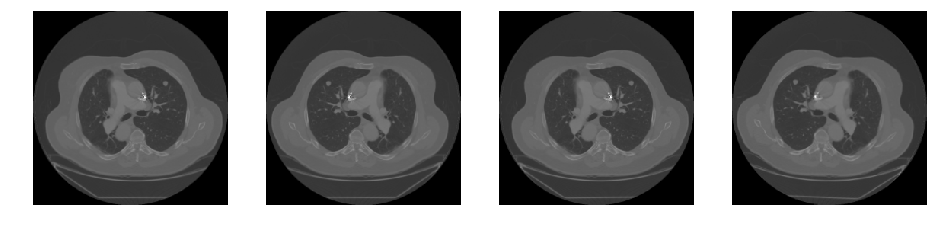

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


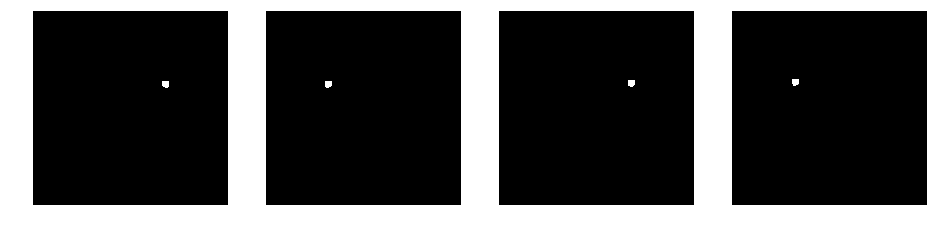

In [39]:
show_augmentation('data/train/image1/1.png', image_generator_train, n_rows=1)
show_augmentation('data/train/label1/1.png', label_generator_train, n_rows=1)

## Instantiate and Train the U-Net

In [40]:
model = unet()
model.compile(
    optimizer = Adam(lr = 1e-4),
    loss=dice_coef_loss,
    metrics = [
        'accuracy',
        tf.keras.metrics.Precision(),
        tf.keras.metrics.Recall(),
        tf.keras.metrics.TrueNegatives(),
        tf.keras.
        metrics.TruePositives()
    ]
)
model_checkpoint = ModelCheckpoint(MODEL_NAME, monitor='loss',verbose=1, save_best_only=True)

In [84]:
model.fit_generator(
  train_generator,
  steps_per_epoch = 2000,
  epochs = 5
)

Epoch 1/5
2000/2000 [==============================] - 339s 170ms/step - loss: 0.9952 - acc: 0.8452 - precision_5: 0.0108 - recall_5: 0.8599 - true_negatives_5: 442699200.0000 - true_positives_5: 883223.0000
Epoch 2/5
2000/2000 [==============================] - 339s 169ms/step - loss: 0.9947 - acc: 0.8742 - precision_5: 0.0139 - recall_5: 0.8916 - true_negatives_5: 457907424.0000 - true_positives_5: 917826.0000
Epoch 3/5
2000/2000 [==============================] - 339s 169ms/step - loss: 0.9941 - acc: 0.8996 - precision_5: 0.0172 - recall_5: 0.8902 - true_negatives_5: 471224896.0000 - true_positives_5: 911365.0000
Epoch 4/5
2000/2000 [==============================] - 339s 169ms/step - loss: 0.9931 - acc: 0.9428 - precision_5: 0.0303 - recall_5: 0.8930 - true_negatives_5: 493854528.0000 - true_positives_5: 918120.0000
Epoch 5/5
2000/2000 [==============================] - 339s 169ms/step - loss: 0.9918 - acc: 0.9752 - precision_5: 0.0695 - recall_5: 0.9056 - true_negatives_5: 5108282

## Test the U-Net

In [113]:
# results = model.predict(X_test, 2, verbose=1)

x1 = np.array(io.imread('data/test/image1/3.png', as_gray=True))
x2 = np.array(io.imread('data/test/image2/3.png', as_gray=True))
x3 = np.array(io.imread('data/test/image3/3.png', as_gray=True))
x4 = np.array(io.imread('data/test/image4/3.png', as_gray=True))
X = np.array([x1, x2, x3, x4])

y1 = np.array(io.imread('data/test/label1/3.png', as_gray=True))
y2 = np.array(io.imread('data/test/label2/3.png', as_gray=True))
y3 = np.array(io.imread('data/test/label3/3.png', as_gray=True))
y4 = np.array(io.imread('data/test/label4/3.png', as_gray=True))
Y = np.array([y1, y2, y3, y4])

Y_hat = model.predict(X.reshape(1, 256, 256, 4, 1))

# Visualize test results

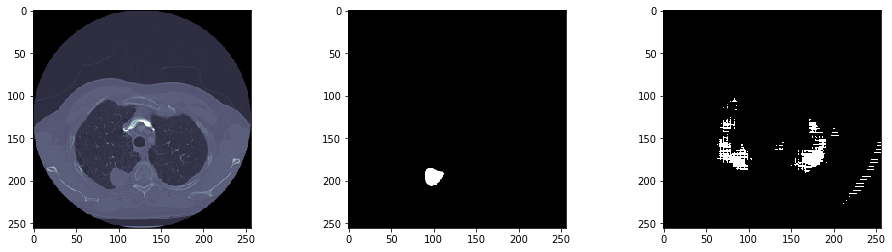

In [114]:
fig, axs = plt.subplots(1, 3, figsize=(16, 4))

axs[0].imshow(X[1], cmap='bone')
axs[1].imshow(Y[1], cmap='bone')
axs[2].imshow(Y_hat[0].reshape(4, 256, 256)[1], cmap='bone')
plt.show()